In [1]:

!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wand

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config
from patterns.grokking import GrokkingLearner, GrokkingConfig

from unifying.sweep import get_history, handle_outliers, extract_run, extract_slice, get_pivot, extract_slice_from_pivot
from unifying.plotting import plot, plot_interpolation_overview, plot_slice, BLUE, RED, BLUES, REDS, plot_all_details, plot_details, create_heatmap
from matplotlib import cm, colors, gridspec


DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

zsh:1: /Users/Jesse/Projects/pattern-learning/.venv/bin/pip: bad interpreter: /Users/Jesse/Projects/unifying-grok-dd/.venv/bin/python: no such file or directory


# Sweeps

To initialize a sweep, run the following command:

```shell
wandb sweep --project grokking <config.yml>
```

where `<config.yml>` is the config file you want to use.

To run the sweep, run the following command:

```shell
wandb agent <sweep_id> --function train
```

where `<sweep_id>` is the id of the sweep you want to run. You can find the sweep id by running `wandb sweep ls`.

You can pass an optional `--count` flag to the `wandb agent` command to specify the number of runs you want to execute. If you don't pass this flag, the agent will run until all the runs in the sweep are complete (for a grid sweep).

On a multi-GPU machine, you can run multiple agents in parallel through the following:

```shell
CUDA_VISIBLE_DEVICES=0 wandb agent <sweep_id> &
CUDA_VISIBLE_DEVICES=1 wandb agent <sweep_id> &
...
```

In [ ]:
import json
import numpy as np

def generate_coarse_to_fine_grid_sweep(min_, max_, total_steps, step_sizes=[10, 5, 3, 1], type_="log"):
    if type_ == "log":
        # Generate the logscale range
        grid = np.logspace(np.log10(min_), np.log10(max_), total_steps)
    elif type_ == "linear":
        grid = np.linspace(min_, max_, total_steps)
    else:
        grid = np.arange(min_, max_, int((max_ - min_) / total_steps))

    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid


def rearrange_coarse_to_fine(grid: List, step_sizes=[10, 5, 3, 1]):
    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid

## Model-wise

In [ ]:
model_grid_1 = generate_coarse_to_fine_grid_sweep(1, 300, 31, step_sizes=[10, 5, 3, 1], type_="log")

# Drop duplicates and convert to int but maintain order
model_grid_1 = list(dict.fromkeys((int(i) for i in model_grid_1)))

model_grid_2 = generate_coarse_to_fine_grid_sweep(0, 300, 100, step_sizes=[10, 5, 3, 1], type_="range")
model_grid_2 = list(dict.fromkeys((int(i) for i in model_grid_2 if int(i) not in model_grid_1 and i)))
print(len(model_grid_2), json.dumps(model_grid_2))

94 [60, 90, 120, 150, 180, 210, 240, 270, 15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 18, 27, 36, 63, 72, 81, 99, 108, 117, 126, 144, 153, 162, 171, 189, 198, 207, 216, 234, 243, 252, 261, 279, 288, 297, 12, 21, 24, 33, 39, 42, 48, 51, 57, 66, 69, 78, 84, 87, 93, 96, 102, 111, 114, 123, 129, 132, 138, 141, 147, 156, 159, 168, 174, 177, 183, 186, 192, 201, 204, 213, 219, 222, 228, 231, 237, 246, 249, 258, 264, 267, 273, 276, 282, 291, 294]


## Sample-wise

In [ ]:
# Frac train 

frac_train_grid = generate_coarse_to_fine_grid_sweep(0, 1.05, 20, step_sizes=[.5, .2, .1, .05], type_="range")
print(frac_train_grid)

In [ ]:
# Frac train 
mnist_frac_train_grid = generate_coarse_to_fine_grid_sweep(0.01, .10, 25, step_sizes=[10, 5, 3, 1], type_="log")
print(mnist_frac_train_grid)

[0.01, 0.026101572156825358, 0.06812920690579612, 0.016155980984398736, 0.042169650342858224, 0.01333521432163324, 0.01778279410038923, 0.023713737056616554, 0.03162277660168379, 0.05623413251903491, 0.07498942093324558, 0.1, 0.011006941712522098, 0.012115276586285882, 0.014677992676220698, 0.019573417814876596, 0.021544346900318832, 0.02872984833353664, 0.03480700588428409, 0.03831186849557287, 0.046415888336127774, 0.05108969774506927, 0.061896581889126036, 0.08254041852680181, 0.09085175756516867]


In [ ]:
# Modulus

import warnings


def sieve_of_eratosthenes(n):
    """
    Generate all prime numbers between 2 and n using the Sieve of Eratosthenes algorithm.
    """
    # Create a boolean array "prime[0..n]" and initialize
    # all entries it as true. A value in prime[i] will
    # finally be false if i is Not a prime, else true.
    prime = [True for i in range(n+1)]
    p = 2
    while p**2 <= n:
        # If prime[p] is not changed, then it is a prime
        if prime[p]:
            # Update all multiples of p
            for i in range(p**2, n+1, p):
                prime[i] = False
        p += 1

    # Generate list of primes
    primes = [p for p in range(2, n+1) if prime[p]]
    return primes


def primes_range(min_, max_, num_primes):
    """
    Generate a list of primes between min_ and max_, 
    following a near-logarithmic scale with num_primes elements.
    """
    all_primes = [p for p in sieve_of_eratosthenes(max_) if p >= min_]

    # Generate the logscale range
    grid = np.logspace(np.log10(min_), np.log10(max_), num_primes)

    # Find the closest prime to each element in the grid
    primes = []
    used_indices = set()

    for i in range(len(grid)):
        # Find the index of the closest prime to the grid element
        idx = np.argmin(np.abs(np.array(all_primes) - grid[i]))
        
        while idx in used_indices:
            idx += 1

        if idx >= len(all_primes):
            warnings.warn(f"Ran out of primes to choose from. Returning {len(primes)} primes.")
            break

        used_indices.add(idx)
        primes.append(all_primes[idx])

    return primes

modulus_grid = rearrange_coarse_to_fine(primes_range(1, 1000, 31), [10, 5, 3, 1])
print(modulus_grid)

[31, 97, 311, 997, 53, 173, 557, 43, 61, 83, 127, 241, 349, 499, 701, 37, 41, 47, 67, 79, 109, 137, 157, 193, 223, 277, 389, 443, 631, 787, 887]


## Regularization-wise

In [ ]:
wds = generate_coarse_to_fine_grid_sweep(0.05, 10, 51)
print(json.dumps(wds))

[0.049999999999999996, 0.14426999059072135, 0.41627660370093655, 1.201124433981431, 3.4657242157757318, 10.0, 0.08493232323171235, 0.24506370946974493, 0.7071067811865475, 2.0402857733683692, 5.887040186524747, 0.06871187569715699, 0.09442643723643111, 0.12976435235830103, 0.17832704098331334, 0.3367757428593863, 0.46280985962343724, 0.6360106709172864, 0.87402972324268, 1.6506302560910038, 2.2683580195698294, 3.1172626855466286, 4.283859323293314, 8.090191470413135, 0.05558922306812267, 0.06180323442635004, 0.07639279571116754, 0.10498184566128109, 0.1167171847313636, 0.16039713377967135, 0.19826123320599312, 0.22042375836898087, 0.27245802423230514, 0.3029145977149917, 0.37442203787486295, 0.5145448104946759, 0.572062924982669, 0.7861503318472239, 0.9717326650701373, 1.0803572776233041, 1.3353914818633272, 1.484667499371428, 1.8351450701767056, 2.5219251989646447, 2.803837248927306, 3.8531383304670337, 4.7627282303001826, 5.29512724014004, 6.545119802794536, 7.2767624945026474, 8.994

In [ ]:
frac_trains = generate_coarse_to_fine_grid_sweep(0.0167, 1., 15, step_sizes=[5, 3, 1], type_="log")
print(json.dumps(frac_trains))

[0.0167, 0.07202123903566399, 0.3106023276785778, 0.040138666638556336, 0.09647380595935064, 0.23187604411707452, 0.5573170800169124, 0.022369964486772486, 0.029964988690985774, 0.05376649983538355, 0.12922847983320082, 0.17310398230828128, 0.4160576670466261, 0.7465367238233578, 1.0]


In [ ]:
lr_gains = generate_coarse_to_fine_grid_sweep(.4, 2.5, 15, step_sizes=[5, 3, 1], type_="log")
print(json.dumps(lr_gains))

# Extensions

## Division

In [2]:
MW_SWEEPS = ["xkfsr247"] # ["i9ary9rm"] # ["l1b2mmci", "662klo00"]
SW_SWEEPS = ["s0iyilba"]  # TODO: Redo for division
RW_SWEEPS = ["ib21hnk1"]

# Model-wise
mw_grokking = get_history(*MW_SWEEPS, unique_cols="d_model")
mw_grokking_cleaned = handle_outliers(
    mw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["d_model"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


# HACK TODO: Finish runs
min_d_model = mw_grokking_cleaned.d_model.min()
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "train/acc"] = 0.0
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "test/acc"] = 0.0

# Sample-wise
sw_grokking = get_history(*SW_SWEEPS, unique_cols="frac_train")
sw_grokking_cleaned = handle_outliers(
    sw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["frac_train"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


NUM_STEPS = sw_grokking._step.max()

# Insert a column for frac_train = 0 with all zeros
# This is true but kind of gross (You can assign 0 accuracy or 1 accuracy when you train on 0% of the data)
# sw_grokking_cleaned = sw_grokking_cleaned.append(
#     pd.DataFrame(
#         {
#             "train/loss": [0.0] * NUM_STEPS,
#             "test/loss": [0.0] * NUM_STEPS,
#             "train/acc": [0.0] * NUM_STEPS,
#             "test/acc": [0.0] * NUM_STEPS,
#             "frac_train": [0.0] * NUM_STEPS,
#             "_step": range(1, NUM_STEPS),
#         }
#     )
# )

# Regularization-Wise 
rw_grokking = get_history(*RW_SWEEPS, unique_cols="weight_decay")
rw_grokking_cleaned = handle_outliers(
    rw_grokking,
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

In [3]:
# Generate the 1x4 grid of Epoch-wise, Model-wise, Sample-wise, and Regularization-wise plots



# Epoch-wise
wd_selection = rw_grokking.weight_decay.unique()[10]
steps, ew_slice = extract_run(rw_grokking_cleaned, weight_decay=wd_selection)

# Extensions
# mw_pivot_train = get_pivot(mw_grokking_cleaned, "d_model", ["train/acc"], reindex=True, interpolate=True, )
# mw_train_slice = extract_slice_from_pivot(mw_pivot_train, 20000, "train/acc", "d_model", smooth=2.)

# mw_pivot_test = get_pivot(mw_grokking_cleaned, "d_model", ["test/acc"], reindex=True, interpolate=True, )
# mw_test_slice = extract_slice_from_pivot(mw_pivot_test, 20000, "test/acc", "d_model", smooth=2.)

# mw_slice = {
#     "train/acc": mw_train_slice["train/acc"],
#     "test/acc": mw_test_slice["test/acc"],
# }
# d_model_vals = mw_test_slice.d_model.unique()

frac_train_vals, sw_slice = extract_slice(sw_grokking_cleaned, 10000, "frac_train")
wd_vals, rw_slice = extract_slice(rw_grokking_cleaned, 10000, "weight_decay")

In [13]:

def extract_slice_from_pivot(pivot_table, step, metric: Union[str, List[str]], unique_col, smooth: Union[bool, float]=False):
    _pivot_table = pivot_table.copy()

    if smooth:
        _pivot_table[metric] = gaussian_filter(pivot_table[metric].values, sigma=smooth)

    slice_ = _pivot_table.loc[_pivot_table.index == step, :].T.reset_index()
    slice_ = pd.melt(
        slice_,
        id_vars=[unique_col, "level_0"],
        var_name="_step",
        value_name=metric,
    )

    return slice_


# Heatmap
def create_heatmap(
    x,
    y,
    z,
    ax,
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_x: bool = True,
    log_y: bool = True,
    log_z: bool = True,
    metric_label: str = "",
    title: str = "",
    flip: bool = True,
):
    X, Y = np.meshgrid(x, y)

    if smooth:
        z = gaussian_filter(z, sigma=smooth)

    if log_z:
        mesh = ax.pcolormesh(X, Y, z, cmap=cmap, norm=LogNorm())
    else:
        mesh = ax.pcolormesh(X, Y, z, cmap=cmap)

    if log_y:
        ax.set_yscale("log")

    if log_x:
        ax.set_xscale("log")

    ax.set_title(metric_label)
    ax.set_xlabel(title)
    ax.set_ylabel("Steps")
    ax.set_ylim(y.max(), y.min())
    ax.set_yticks([10**i for i in range(0, int(np.floor(np.log10(y.max()))))] + [y.max()])
    ax.set_xlim(x[0], x[-1])

    if flip:
        ax.invert_yaxis()

    return mesh

def plot_details(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    log_loss=True,
    cmap="inferno",
    log_x: bool = True,
    log_y: bool = True,
    log_time: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    step: int = 10000,
    run_val: float = 0.0,
    plot_extra: bool = False,
    gs: Optional[Union[gridspec.GridSpec, gridspec.GridSpecFromSubplotSpec]] = None,
    fig: Optional[plt.Figure] = None,
    flip: bool = True,
):
    # Figure:
    # - Top Row: Heatmap stretching across
    # - Bottom Row: Two line plots.

    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

        
    # create a figure with a 2x2 grid of subplots
    fig = fig or plt.figure(figsize=(10, 6))

    gs = gs or gridspec.GridSpec(2, 4, width_ratios=[1.59, 6, 6, 1.59])
    
    ax1 = plt.subplot(gs[0, 1:])
    ax2 = plt.subplot(gs[1, 1])
    ax3 = plt.subplot(gs[1, 2])

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    xmin, xmax = unique_vals[0], unique_vals[-1]
    xticks = [10**i for i in range(int(np.floor(np.log10(xmin))), int(np.ceil(np.log10(xmax)))) if 10**i >= xmin and 10**i <= xmax]

    if xmin not in xticks:
        xticks = [xmin, *xticks]
    
    if xmax not in xticks:
        xticks = [*xticks, xmax]

    mesh = create_heatmap(
        x=unique_vals,
        y=pivot_table[metric].index,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
        flip=flip
    )

    ax1.set_ylabel("Steps", fontsize=18)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)

    fig.colorbar(mesh, ax=ax1)
    
    # Plot a vertical line at unique_col = run_val
    ax1.axvline(x=run_val, color=BLUE, linestyle="--", linewidth=1)

    # Plot a horizontal line at step = step
    ax1.axhline(y=step, color=RED, linestyle="--", linewidth=1)

    # Line plots

    # Slice
    slice_ = extract_slice_from_pivot(pivot_table, step, metric, unique_col, smooth=smooth)

    if plot_extra:
        num_steps = len(df._step.unique())
        # Plot one slice every 100 steps
        slices_table = pivot_table.loc[pivot_table.index % 10 == 0, :].T.reset_index()
        slices = pd.melt(
            slices_table,
            id_vars=[unique_col, "level_0"],
            var_name="_step",
            value_name=metric,
        )

        sns.lineplot(
            data=slices,
            x=unique_col,
            y=metric,
            hue="_step",
            ax=ax2,
            alpha=100.0 / num_steps,
            palette=REDS,
            legend=False,
        )
        slice_norm = colors.Normalize(vmin=0, vmax=df._step.max())
        slice_colorbar = cm.ScalarMappable(norm=slice_norm, cmap=REDS)
        fig.colorbar(slice_colorbar, ax=ax2, label="Steps")
    
    ax2.plot(unique_vals, slice_[metric], label=title, color=RED)
    ax2.set_xlabel(title, fontsize=18)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks)

    # Run example
    kwargs = {unique_col: run_val}
    steps, run = extract_run(df, **kwargs)

    if plot_extra:
        num_vals = len(unique_vals)
        sns.lineplot(
            data=df,
            x="_step",
            y=metric,
            hue=unique_col,
            ax=ax3,
            alpha=10.0 / num_vals,
            palette=BLUES,
            legend=False,
        )
        run_norm = colors.Normalize(vmin=min(unique_vals), vmax=max(unique_vals))
        run_colorbar = cm.ScalarMappable(norm=run_norm, cmap=BLUES)
        fig.colorbar(run_colorbar, ax=ax3, label=title)

    ax3.plot(steps, run[metric], label=title, color=BLUE)
    ax3.set_xlabel("Steps", fontsize=18)

    for ax in [ax2, ax3]:
        if "Accuracy" in metric_label:
            ax.set_ylim(0.0, 1.05)
        else:
            min_loss, max_loss = df[metric].min(), df[metric].max()
            
            if log_loss:
                ax.set_ylim(0.5 * min_loss, 1.5 * max_loss)
                ax.set_yscale("log")
            else:
                ax.set_ylim(-0.05 * max_loss, 1.05 * max_loss)

        if log_x:
            ax.set_xscale("log")

    if log_time:
        ax3.set_xscale("log")

    ax2.set_ylabel(metric_label_short, fontsize=18)
    ax3.set_yticklabels([])
    ax3.set_ylabel("")

    # Adjust the layout of the subplots
    # fig.suptitle(title)
    # fig.tight_layout()

    ax1.annotate(title, (0.5, 1), xytext=(0, 30), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=20)

    # Fontsize
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.tick_params(axis="both", which="minor", labelsize=12)

    return fig


def plot_all_details(
    df,
    title,
    unique_col,
    run_val,
    log_x=True,
    log_y=True,
    plot_extra=False,
    cmap="viridis",
    metrics_and_labels=[
        ("train/acc", "Train Accuracy"),
        ("test/acc", "Test Accuracy"),
        ("train/loss", "Train Loss"),
        ("test/loss", "Test Loss"),
    ],
    format="png",
    **kwargs
):
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.025)

    if run_val not in df[unique_col].values:
        raise ValueError(f"run_val={run_val} not in unique_vals={df[unique_col].values}")

    for i, (metric, label) in enumerate(metrics_and_labels):
        I, J = i // 2, i % 2
        sub_gs = gs[I, J].subgridspec(2, 4, width_ratios=[1.59, 6, 6, 1.59], hspace=0.75, wspace=0.15)

        plot_details(
            df,
            metric_label=label,
            metric=metric,
            title=label,
            unique_col=unique_col,
            run_val=run_val,
            cmap=cmap,
            log_x=log_x,
            log_y=log_y,
            plot_extra=plot_extra,
            gs=sub_gs,
            fig=fig,
            **kwargs
        )
    
    # fig.tight_layout(h_pad=0.5, w_pad=5)
    # fig.savefig(f"../figures/{unique_col}.{format}", dpi=300)
    plt.show()



In [14]:
api = wandb.Api()
runs = api.runs("initially-overconf-learners/grokking")

desired_config = {
    "lr": 0.001,
    "train_split": 50,
    "weight_decay": 0.00001,
    "num_heads": 1,
    "num_layers": 2,
}

def filter_config(config):
    for k, v in desired_config.items():
        if config.get(k) != v:
            return False
    
    return True

accepted = [r for r in runs if filter_config(r.config) and r.state == "finished" and "train_step" in r.summary and r.summary["train_step"] == r.config["optimization_budget"]]
rejects = [r for r in runs if r not in accepted]

len(accepted), len(rejects)

KeyboardInterrupt: 

In [95]:
KEYS = ["Accurcy/train", "Accuracy/val", "Loss/train", "Loss/val", "train_step"]

def get_history(run):
    """Get a dataframe for a single sweep."""

    def create_run_df(history, config):
        for k, v in config.items():
            if k == "momentum" and isinstance(v, list):
                v = [tuple(v)] * len(history)
            history[k] = v

        return history

    return pd.concat([create_run_df(run.history(keys=KEYS), run.config) for run in runs])


def combine_histories(
    histories,
    unique_cols: Union[List[str], str] = "weight_decay",
    allow_duplicates: bool = False,
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]
    histories = pd.concat(histories)

    # Change column names
    histories = histories.rename(columns={"train_step": "_step", "Accuracy/train": "train/acc", "Accuracy/val": "test/acc", "Loss/val": "train/loss", "Loss/test": "test/loss", "Loss/train/avg": "train/loss/avg", "Loss/test/avg": "test/loss/avg"})

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    return histories

In [66]:
histories = []
START = 0

for run in tqdm(accepted[START:]):
    print(run)
    histories.append(run.history())
    
# combine_histories(histories, unique_cols=["d_model"])
histories[0].columns

  0%|          | 0/84 [00:00<?, ?it/s]

<Run initially-overconf-learners/grokking/j4xzi7m6 (finished)>
<Run initially-overconf-learners/grokking/ly037cix (finished)>
<Run initially-overconf-learners/grokking/pb54pc8x (finished)>
<Run initially-overconf-learners/grokking/gcpbs2lg (finished)>
<Run initially-overconf-learners/grokking/jzbfz6xw (finished)>
<Run initially-overconf-learners/grokking/li634j30 (finished)>
<Run initially-overconf-learners/grokking/pcap580g (finished)>
<Run initially-overconf-learners/grokking/8yy6qi1e (finished)>
<Run initially-overconf-learners/grokking/eyfgd5kn (finished)>
<Run initially-overconf-learners/grokking/0clfa1e4 (finished)>
<Run initially-overconf-learners/grokking/hnpvi6im (finished)>
<Run initially-overconf-learners/grokking/z578coju (finished)>
<Run initially-overconf-learners/grokking/lmqkw14z (finished)>
<Run initially-overconf-learners/grokking/8hgm9hz2 (finished)>
<Run initially-overconf-learners/grokking/iubor7cm (finished)>
<Run initially-overconf-learners/grokking/c4t8pysq (fin

In [136]:
KEYS = ["Accuracy/train", "Accuracy/val", "Loss/train", "Loss/val", "train_step"]

# Drop all other columns
histories_trimmed = [h[KEYS] for h in histories]
histories_trimmed[0]

# Rename columns
histories_trimmed = [h.rename(columns={"train_step": "_step", "Accuracy/train": "train/acc", "Accuracy/val": "test/acc", "Loss/train": "train/loss", "Loss/val": "test/loss",}) for h in histories_trimmed]
for i, h in enumerate(histories_trimmed):
    h["d_model"] = accepted[i].config["d_model"]

histories_combined = pd.concat(histories_trimmed)

# Order by d_model, then step
histories_combined = histories_combined.sort_values(by=["d_model", "_step"])

# Save to csv
histories_combined.to_csv("../data/mw_sweep.csv", index=False)

[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  44  45  47  49  50  51  53  55  57  59  61  63  65  67
  68  69  71  73  74  75  77  79  80  81  83  86  89  92  95  98 101 104
 107 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158
 161 164 167 170]


,train/acc,test/acc,train/loss,test/loss,_step,d_model
172,0.003906,0.007947,7.533011,7.525016,172,1
244,0.021484,0.007947,7.453745,7.454717,244,1
369,0.015625,0.007947,7.281325,7.289794,369,1
404,0.005859,0.007947,7.245758,7.234515,404,1
418,0.025391,0.007947,6.913494,6.943035,561,1
...,...,...,...,...,...,...
382,NaN,0.993986,NaN,0.072970,397970,170
472,1.000000,NaN,0.000002,NaN,398440,170
404,1.000000,NaN,0.000016,NaN,398910,170
186,NaN,0.997852,NaN,0.029595,399320,170


In [5]:
histories_combined = pd.read_csv("../data/mw_sweep.csv")
d_model_vals = histories_combined.d_model.unique()
print(d_model_vals)
histories_combined

[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  44  45  47  49  50  51  53  55  57  59  61  63  65  67
  68  69  71  73  74  75  77  79  80  81  83  86  89  92  95  98 101 104
 107 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158
 161 164 167 170]


,train/acc,test/acc,train/loss,test/loss,_step,d_model
0,0.003906,0.007947,7.533011,7.525016,172,1
1,0.021484,0.007947,7.453745,7.454717,244,1
2,0.015625,0.007947,7.281325,7.289794,369,1
3,0.005859,0.007947,7.245758,7.234515,404,1
4,0.025391,0.007947,6.913494,6.943035,561,1
...,...,...,...,...,...,...
41995,NaN,0.993986,NaN,0.072970,397970,170
41996,1.000000,NaN,0.000002,NaN,398440,170
41997,1.000000,NaN,0.000016,NaN,398910,170
41998,NaN,0.997852,NaN,0.029595,399320,170


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_6378/1949967539.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y.max(), y.min())
/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_6378/1949967539.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y.max(), y.min())
/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

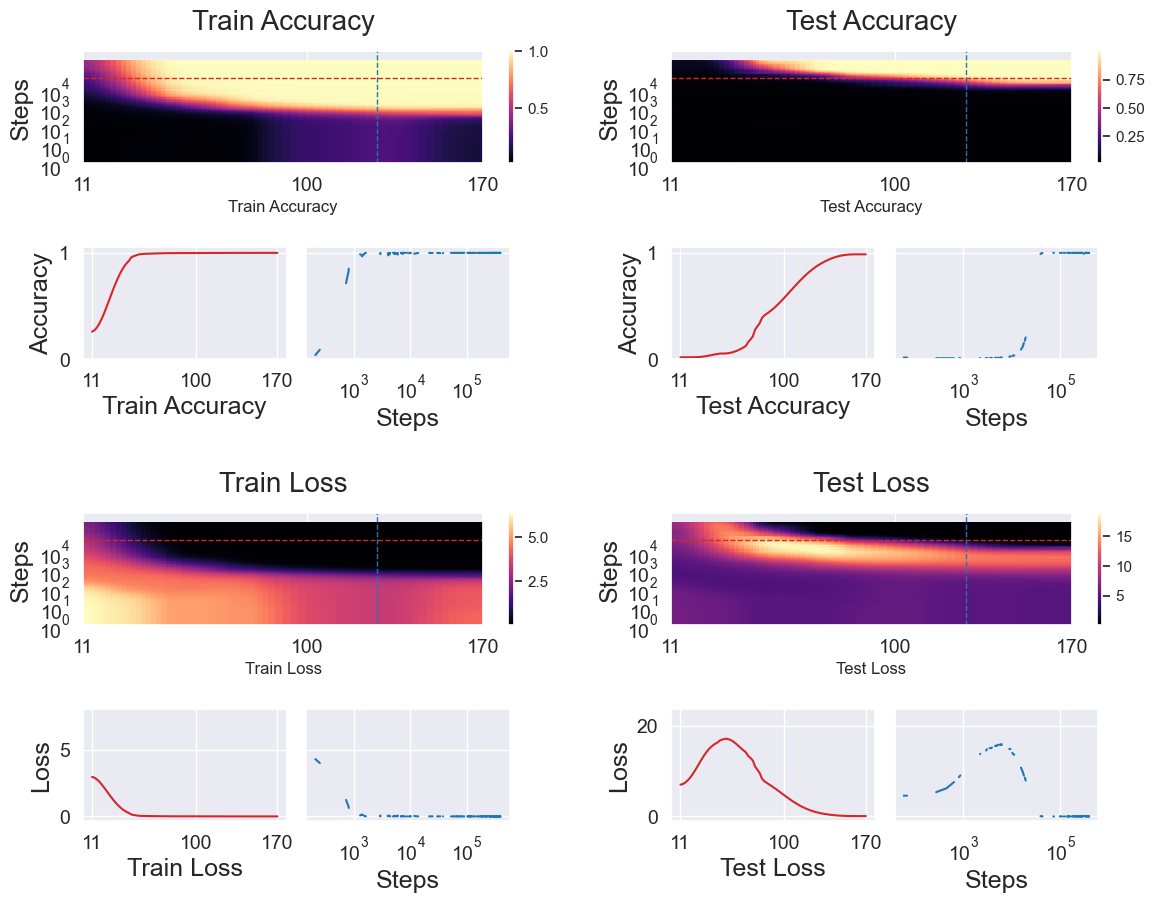

In [16]:
# Model-wise Details
D_MODEL = 128
# Omit all runs with d_model < 30
mw = histories_combined[histories_combined.d_model >= 10]
STEP = 40_000
plot_all_details(mw, title="Embedding dim.", unique_col="d_model", run_val=D_MODEL, plot_extra=False, smooth=(2, 4), step=STEP, cmap="magma", log_x=False, log_time=True, flip=False, log_loss=False)

[0.1, 0.55] 0.05 0.55


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


[0.1, 0.55] 0.05 0.55


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


[0.1, 0.55] 0.05 0.55


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


[0.1, 0.55] 0.05 0.55


/Users/Jesse/Projects/pattern-learning/unifying/sweep.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


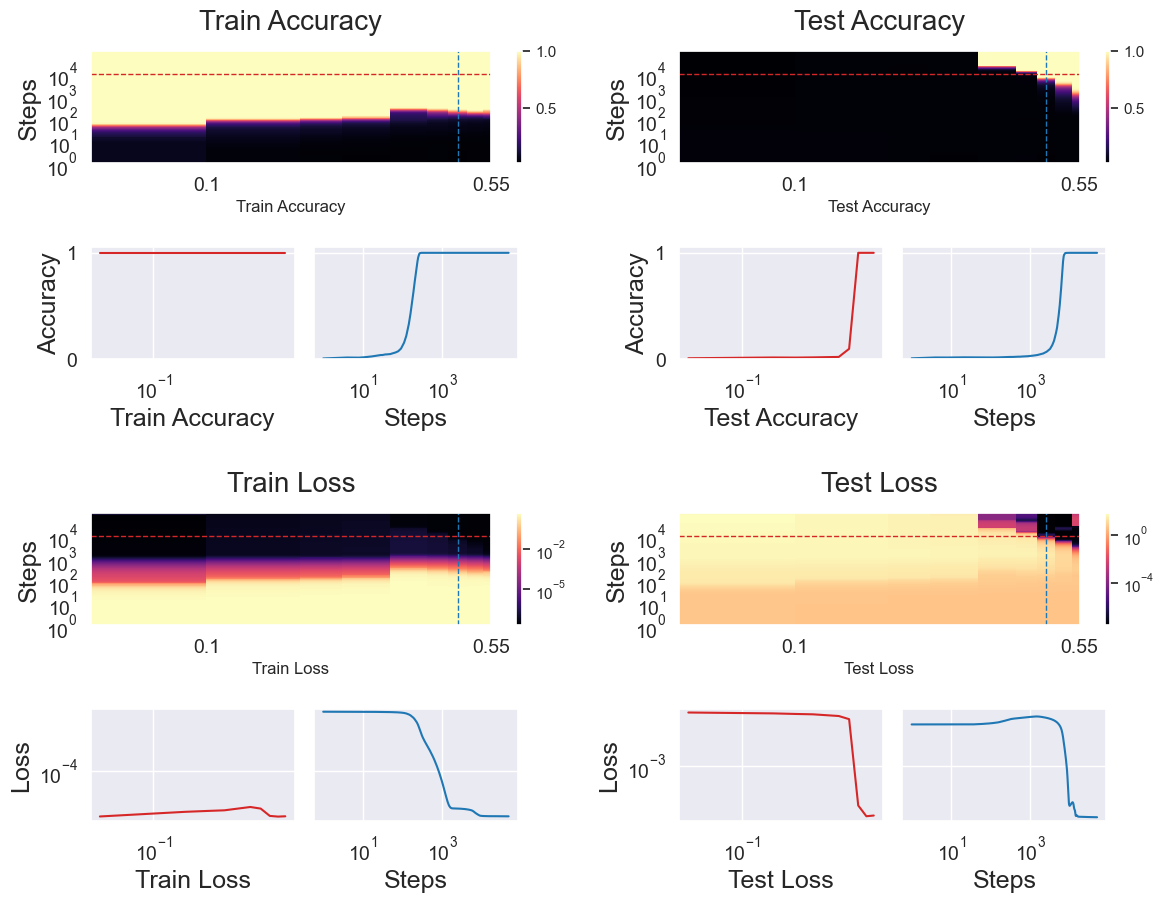

In [171]:
# Sample-wise Details

# plot_curves_2x2(sw_grokking_cleaned, title="Fraction of Training Data", unique_col="frac_train")

# plot_slice(sw_grokking_cleaned, 10000, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Fraction of Training Data", unique_col="frac_train", log_x=False)

# plot(sw_grokking_cleaned, smooth=0.25, log_loss=True, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, unique_col="frac_train", title="Training Fraction", log_x=False, log_y=False)

frac_trains = sw_grokking_cleaned.frac_train.unique()
frac_train_selection = frac_trains[6] 

frac_train_bads = frac_trains[-5:]
# Delete the bad run
sw_grokking_cleaned_2 = sw_grokking_cleaned[~sw_grokking_cleaned.frac_train.isin(frac_train_bads)]

plot_all_details(sw_grokking_cleaned_2, title="Training fraction", unique_col="frac_train", run_val=frac_train_selection, plot_extra=False, cmap="magma")

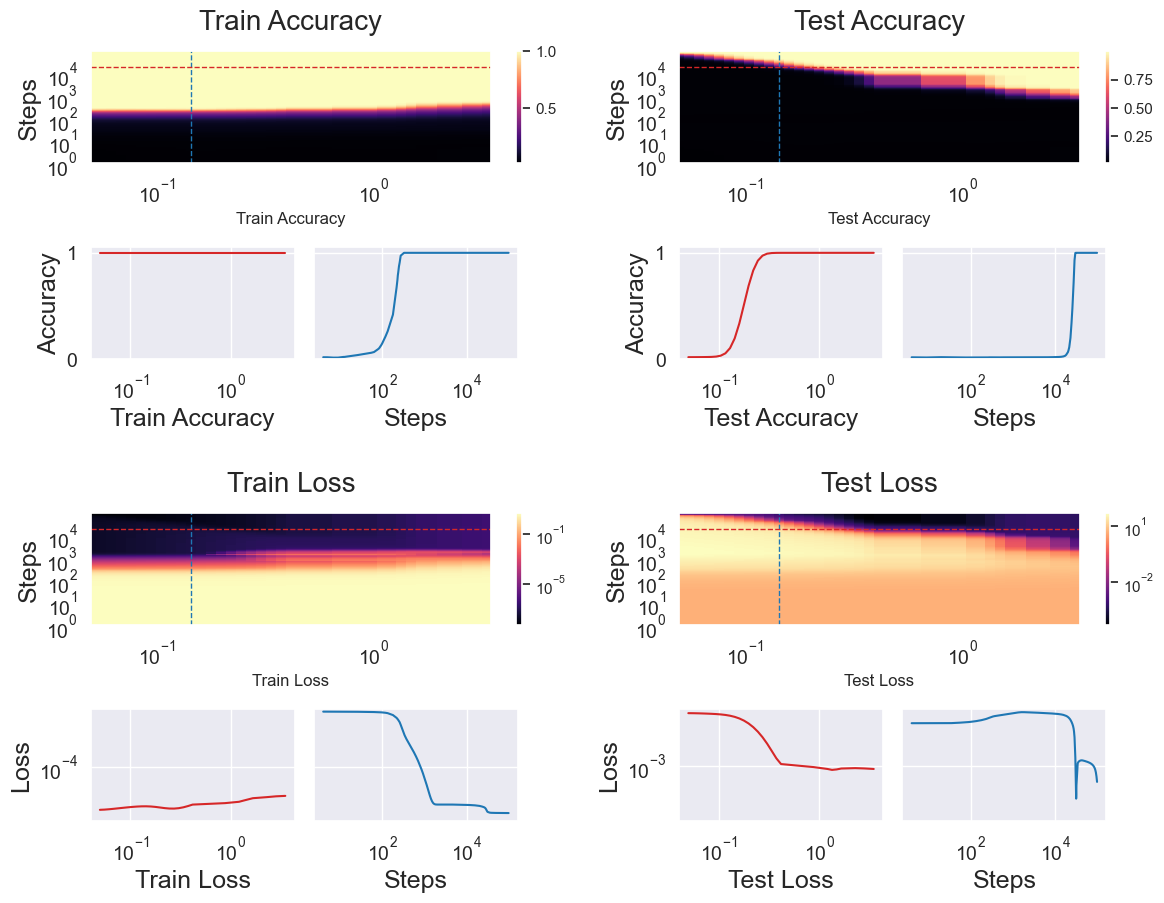

In [154]:
# Regularization-wises Details

# plot_curves_2x2(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay")
# plot_slice(rw_grokking_cleaned, 10010, smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")

# plot(rw_grokking_cleaned,   smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")


plot_all_details(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay", run_val=wd_selection, plot_extra=False, cmap="magma", smooth=2., log_loss=True, step=20_000)

# Grid

In [6]:
pivot_table_train = get_pivot(histories_combined, "d_model", columns=["train/acc"], reindex=True, interpolate=True)
pivot_table_test = get_pivot(histories_combined, "d_model", columns=["test/acc"], reindex=True, interpolate=True)
STEP = 40000
# Get the closest _step to TARGET_STEP
# STEP = pivot_table._step.iloc[(pivot_table._step - TARGET_STEP).abs().argsort()[:1]].values[0]
# print(STEP)
mw_slice_train_acc = extract_slice_from_pivot(pivot_table_train, STEP, "train/acc", "d_model", smooth=(10, 4))
mw_slice_test_acc = extract_slice_from_pivot(pivot_table_test, STEP, "test/acc", "d_model", smooth=(10, 4))

mw_slice = pd.DataFrame({
    "d_model": mw_slice_train_acc.index,
    "train/acc": mw_slice_train_acc["train/acc"].values,
    "test/acc": mw_slice_test_acc["test/acc"].values,
})

<Axes: title={'center': 'MW Sweep'}, xlabel='d_model', ylabel='Accuracy'>

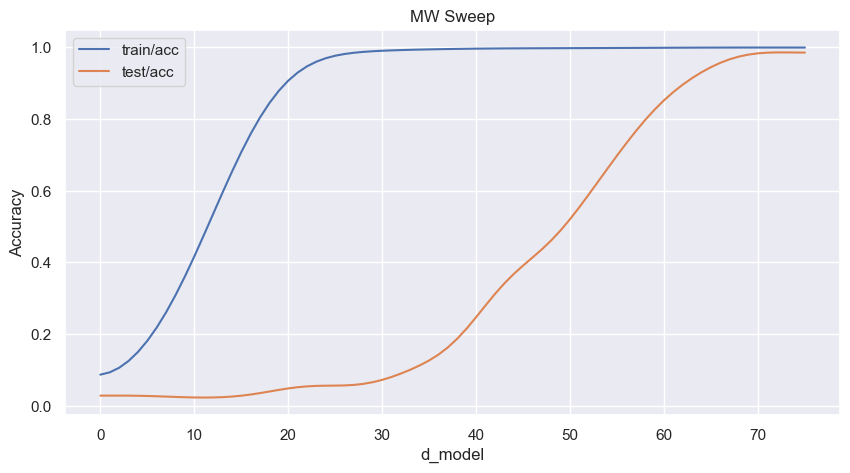

In [9]:
mw_slice.plot(x="d_model", y=["train/acc", "test/acc"], logx=False, logy=False, figsize=(10, 5), title="MW Sweep", xlabel="d_model", ylabel="Accuracy", legend=True, color=["C0", "C1"])

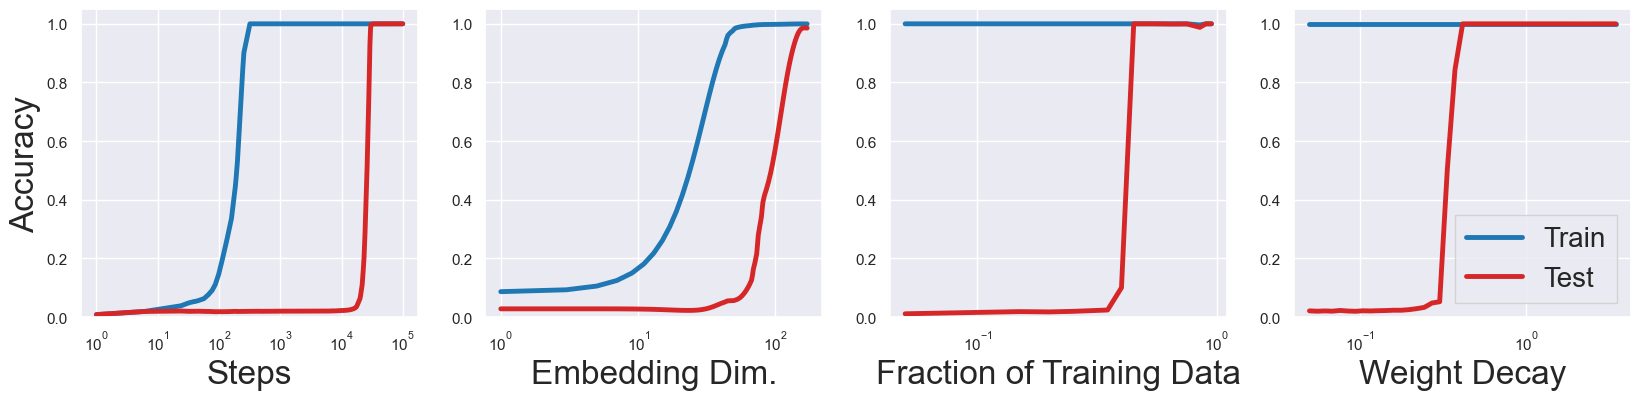

In [12]:
# Plot the 1x4 grid

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

titles = ["Epoch-wise", "Model-wise", "Sample-wise", "Regularization-wise"]
xlabels = ["Steps", "Embedding Dim.", "Fraction of Training Data", "Weight Decay"]
ylabels = ["Accuracy", "", "", ""]
data = [(steps, ew_slice), (d_model_vals, mw_slice), (frac_train_vals, sw_slice), (wd_vals, rw_slice)]

for ax, title, xlabel, ylabel, (x, y) in zip(axes, titles, xlabels, ylabels, data):

    ax.set_ylim(0., 1.05)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.plot(x, y["train/acc"], label="Train", color=BLUE, linewidth=3.5)
    ax.plot(x, y["test/acc"], label="Test", color=RED, linewidth=3.5)

    # Increase the font size of the x and y labels
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)


axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[3].set_xscale('log')

# Add a legend at the bottom of all the plots (to be shared)
# axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), fancybox=False, shadow=False, ncol=2)
# axes[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
axes[3].legend(fontsize=20, loc='lower right', fancybox=False, shadow=False, ncol=1)

fig.savefig("../figures/grokking_extensions.pdf", bbox_inches='tight')

# Interpolations

In [ ]:

def plot_interpolation_overview(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
):
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[3, 2], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table[metric].index
    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
    )

    fig.colorbar(mesh, ax=ax1, label="Test Accuracy")

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * 0.95
        interp_step = run.loc[run["train/acc"] > interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    ax1.plot(
        unique_vals,
        [v for (v, _) in convergence],
        color="grey",
        linestyle="--",
        label="Convergence",
    )

    for i, val in enumerate(run_vals):
        run = df.loc[(df[unique_col] == val), :]
        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)

        interp_step, interp_val = interpolation[unique_val_idx]
        ax.vlines(interp_step, 0, interp_val, color="grey", linestyle="--", label=None)

        # Test convergence threshold
        conv_step, conv_val = convergence[unique_val_idx]
        ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run["train/acc"], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)
        ax.set_title(f"{metric_label_short} for ${latex}={val_rounded}$")

        ax.set_ylim([0.0, 1.05])
        ax.set_xscale("log")
        ax.set_xlim([1e0, df._step.max()])

        if i < len(run_vals) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Step")

        if i == 0:
            ax.legend(loc="lower right")

    plt.suptitle(suptitle)


In [ ]:
ln_sweep = get_history("xwna3rhg", allow_duplicates=True)

# ln_sweep_cleaned = handle_outliers(
#     ln_sweep,
#     loss_cols=["train/loss"], 
#     action="keep",
#     unique_cols=["frac_train"],
#     threshold=0.0001,
#     late_epochs_ratio=0.6,
# )


def correct_label_noise(df: pd.DataFrame):
    # Correct the sweeps by dividing test/acc by 1-label_noise
    df = df.copy()

    lbl_noises = df.frac_label_noise.unique()

    for lbl_noise in lbl_noises:
        for metric in ["test/acc"]:
            df.loc[df.frac_label_noise==lbl_noise, metric] /= 1 - lbl_noise

    return df

ln_sweep_cleaned = correct_label_noise(ln_sweep)

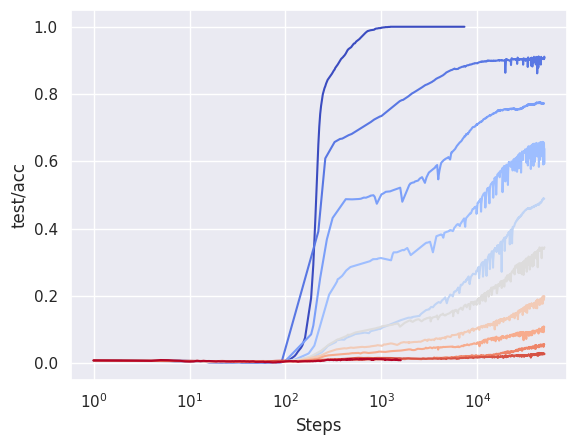

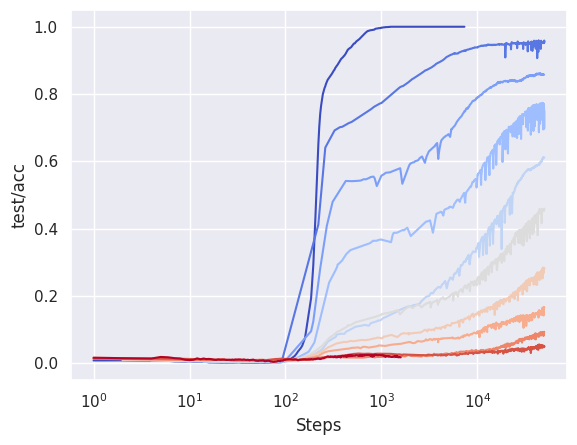

In [ ]:
sns.lineplot(ln_sweep, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

sns.lineplot(ln_sweep_cleaned, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

In [ ]:
plot_interpolation_overview(
    ln_sweep_cleaned,
    unique_col="frac_label_noise",  
    title="Fraction training noise",
    cmap="coolwarm",
    run_vals=[0.0, 0.05, 0.15],
    latex=r"f_\mathrm{noise}",
    log_x=False,
    suptitle="Modular Arithmetic"
)   

NameError: name 'gridspec' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
frac_train_sweep = get_history("cnr2n43n", "759uhy5f", allow_duplicates=True, project="mnist-grokking")

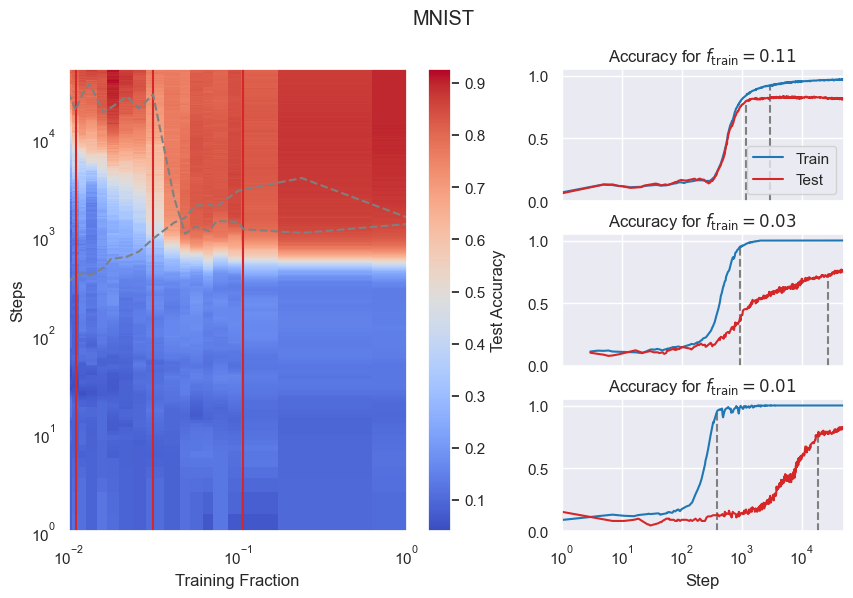

In [ ]:
ft_vals = sorted(frac_train_sweep.frac_train.unique())
ft_selection = [ft_vals[-3], ft_vals[8], ft_vals[1]]

plot_interpolation_overview(
    frac_train_sweep,
    unique_col="frac_train",
    title="Training Fraction",
    cmap="coolwarm",
    run_vals=ft_selection,
    latex=r"f_\mathrm{train}",
    log_x=True,
    suptitle="MNIST"
) 

In [ ]:
api = wandb.Api()
mnist_dd = api.run("jqhoogland/mnist-grokking/hbw3nlnb")
mnist_grok = api.run("jqhoogland/mnist-grokking/9i790lal")

mnist_dd_df = pd.DataFrame(mnist_dd.history())
mnist_grok_df = pd.DataFrame(mnist_grok.history())

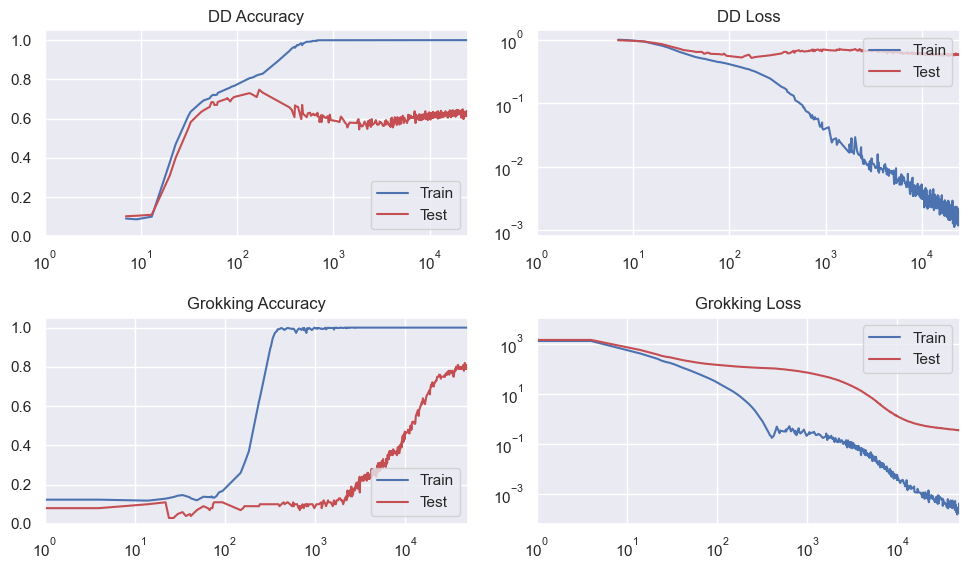

In [ ]:
# 2 by 2 grid of subplots
# Acc on left, loss on right
# DD on top, Grokking on bottom
# Train in blue, test in red

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, (df, title) in enumerate(zip([mnist_dd_df, mnist_grok_df], ["DD", "Grokking"])):
    ax = axes[i, 0]
    # Sort by steps
    df = df.sort_values("_step")

    ax.plot(df._step, df["train/acc"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/acc"], color=RED, label="Test")
    ax.set_title(f"{title} Accuracy")
    ax.set_ylim([0., 1.05])
    ax.set_xscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="lower right")

    ax = axes[i, 1]
    ax.plot(df._step, df["train/loss"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/loss"], color=RED, label="Test")
    ax.set_title(f"{title} Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="upper right")

# More space between rows
fig.tight_layout(pad=1.5)


## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define an empty dataset
class EmptyDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return 0

    def __getitem__(self, index):
        pass

# Create an empty dataset object
empty_dataset = EmptyDataset()

# Create an empty dataloader
dataloader = DataLoader(empty_dataset, batch_size=32, shuffle=True)

# Iterate over the dataloader (won't execute any iterations since the dataset is empty)
for batch in dataloader:
    print(batch)


ValueError: num_samples should be a positive integer value, but got num_samples=0